<a href="https://colab.research.google.com/github/ammierie/Hamoye-quiz-submission/blob/main/Hamoye_Stage_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
from datetime import datetime

In [ ]:
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [ ]:
df = pd.read_csv('/content/time_data.csv', low_memory=False,
                       infer_datetime_format=True, parse_dates=['FullDate'],date_parser=custom_date_parser,index_col=["FullDate"])

In [ ]:
print(df)

                     Tmax     SysLoad  GasPrice  ElecPrice
FullDate                                                  
2010-09-01 00:00:00  15.8  1688.21500    3.6900     23.710
2010-09-01 01:00:00  15.8  1669.19500    3.6900     22.635
2010-09-01 02:00:00  15.8  1491.98000    3.6900     22.565
2010-09-01 03:00:00  15.8  1330.76000    3.6900     18.910
2010-09-01 04:00:00  15.8  1247.94000    3.6900     18.030
...                   ...         ...       ...        ...
2021-02-28 19:00:00  24.3   449.63625    5.4848    117.925
2021-02-28 20:00:00  24.3   815.59975    5.4848     87.880
2021-02-28 21:00:00  24.3   745.12325    5.4848     62.060
2021-02-28 22:00:00  24.3   694.95150    5.4848     62.000
2021-02-28 23:00:00  24.3   714.69630    5.4848     62.955

[92016 rows x 4 columns]


In [ ]:
df.isna().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [ ]:
#downsample data to daily data points
df_daily = df.resample('D').sum()
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-09-01 to 2021-02-28
Freq: D
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       3834 non-null   float64
 1   SysLoad    3834 non-null   float64
 2   GasPrice   3834 non-null   float64
 3   ElecPrice  3834 non-null   float64
dtypes: float64(4)
memory usage: 149.8 KB


Text(0, 0.5, 'G_A_P')

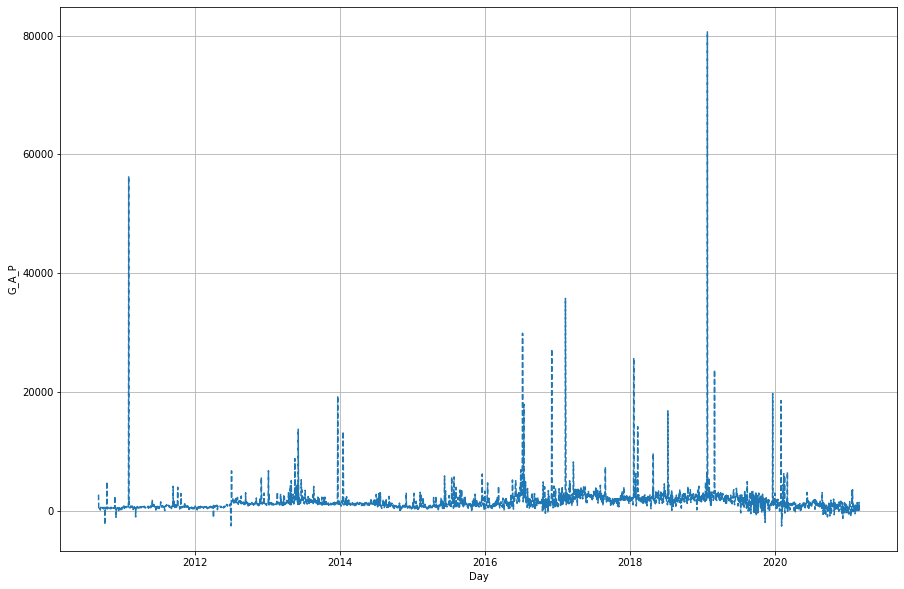

In [ ]:
#plot of the daily global_active_power over time
plt.figure(figsize=(15,10))
plt.plot(df_daily.index, df_daily.ElecPrice, '--')
plt.grid()
plt.xlabel('Day')
plt.ylabel('G_A_P')

In [ ]:
!pip install statsmodels
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
adf_result = adfuller(df_daily['SysLoad'])
print(f'p-value: {round(adf_result[1],6)}')

p-value: 0.004254


In [ ]:
adf_result = adfuller(df_daily['GasPrice'])
print(f'p-value: {round(adf_result[1],6)}')

p-value: 0.045027


In [ ]:
adf_result = adfuller(df_daily['GasPrice'])
print('Critical Values:')
for k, v in adf_result[4].items():
 print(f'{k} : {v}')

Critical Values:
1% : -3.4320693157877544
5% : -2.8622996992165364
10% : -2.5671743978048323


In [ ]:
adf_result = adfuller(df_daily['ElecPrice'])
print('Critical Values:')
for k, v in adf_result[4].items():
 print(f'{k} : {v}')

Critical Values:
1% : -3.432066157296446
5% : -2.8622983040036005
10% : -2.5671736550459663


In [ ]:
# reset index
df_daily = df_daily.reset_index()
df_daily.head()

,index,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,0,2010-09-01,379.2,41565.380,88.56,2751.700
1,1,2010-09-02,369.6,38898.990,88.56,570.810
2,2,2010-09-03,439.2,41665.760,106.80,504.975
3,3,2010-09-04,328.8,35638.085,81.36,502.275
4,4,2010-09-05,357.6,35611.410,106.80,500.555


In [ ]:
# select columns for predictive model
model_data = df_daily[['FullDate', 'ElecPrice']]

#rename columns to 'ds' and 'y' respectively
model_data = model_data.rename(columns={'FullDate':'ds', 'ElecPrice':'y'})

In [ ]:
# assign train and test data
train = model_data[:2757]
test = model_data[2757:]
print('train shape', train.shape)
print('test shape', test.shape)

train shape (2757, 2)
test shape (1077, 2)


In [ ]:
# fit train data to Fbprophet model
from fbprophet import Prophet
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# predict for the next 365 days
#future = model.make_future_dataframe(periods=365, freq='D') 
forecast = model.predict(test) 
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,2691.764386,331.260010,4848.332204,2691.764386,2691.764386,-155.426892,-155.426892,-155.426892,9.749221,9.749221,9.749221,-165.176114,-165.176114,-165.176114,0.0,0.0,0.0,2536.337494
1,2018-03-21,2692.580955,165.679015,4941.536011,2692.580955,2692.580955,-2.925496,-2.925496,-2.925496,159.308129,159.308129,159.308129,-162.233625,-162.233625,-162.233625,0.0,0.0,0.0,2689.655459
2,2018-03-22,2693.397524,498.248080,5331.775209,2693.397524,2693.397524,95.308217,95.308217,95.308217,257.036327,257.036327,257.036327,-161.728110,-161.728110,-161.728110,0.0,0.0,0.0,2788.705741
3,2018-03-23,2694.214093,254.550947,4954.899322,2694.214093,2694.214093,-113.236873,-113.236873,-113.236873,50.257478,50.257478,50.257478,-163.494350,-163.494350,-163.494350,0.0,0.0,0.0,2580.977221
4,2018-03-24,2695.030663,-40.331265,4555.726440,2695.030663,2695.030663,-438.662722,-438.662722,-438.662722,-271.372061,-271.372061,-271.372061,-167.290660,-167.290660,-167.290660,0.0,0.0,0.0,2256.367941


In [ ]:
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,2536.337494,331.260010,4848.332204,2691.764386,2691.764386,2691.764386
1,2018-03-21,2689.655459,165.679015,4941.536011,2692.580955,2692.580955,2692.580955
2,2018-03-22,2788.705741,498.248080,5331.775209,2693.397524,2693.397524,2693.397524
3,2018-03-23,2580.977221,254.550947,4954.899322,2694.214093,2694.214093,2694.214093
4,2018-03-24,2256.367941,-40.331265,4555.726440,2695.030663,2695.030663,2695.030663
...,...,...,...,...,...,...,...
1072,2021-02-24,3475.863766,562.028108,6405.895569,3567.126543,1853.077365,5238.192316
1073,2021-02-25,3542.743730,581.947100,6518.261096,3567.943112,1851.902871,5241.308126
1074,2021-02-26,3309.660718,318.590861,6309.128347,3568.759681,1850.728377,5244.423937
1075,2021-02-27,2966.465610,2.430915,6036.449036,3569.576250,1849.553883,5247.500500


In [ ]:
from sklearn.metrics import mean_squared_error

def mape(test,forecast):
  mape = np.mean(np.abs(np.array(test['y']) - np.array(forecast.yhat))/ np.array(test['y'])) *100
  rmse = np.sqrt(mean_squared_error(np.array(test['y']),np.array(forecast['yhat'])))
  return f'mape value is: {round(mape,2)} and rmse value is: {round(rmse,2)}'

In [ ]:
mape(test,forecast)

'mape value is: -134.17 and rmse value is: 3218.16'

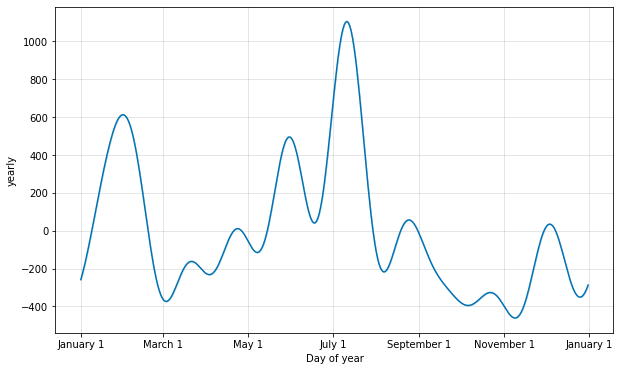

In [ ]:
from fbprophet.plot import plot_yearly
plot_yearly(model)

In [ ]:
multi_model = df_daily.rename(columns = {'FullDate':'ds','ElecPrice':'y',
                                           'SysLoad':'add1','Tmax':'add2',
                                           'GasPrice':'add3'})
multi_model.head()

,index,ds,add2,add1,add3,y
0,0,2010-09-01,379.2,41565.380,88.56,2751.700
1,1,2010-09-02,369.6,38898.990,88.56,570.810
2,2,2010-09-03,439.2,41665.760,106.80,504.975
3,3,2010-09-04,328.8,35638.085,81.36,502.275
4,4,2010-09-05,357.6,35611.410,106.80,500.555


In [ ]:
# assign train and test data
train2 = multi_model[:2757]
test2 = multi_model[2757:]
print('train shape', train2.shape)
print('test shape', test2.shape)

train shape (2757, 6)
test shape (1077, 6)


In [ ]:
#creat multivariate model
model2 = Prophet()
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')

In [ ]:
model2.fit(train2)
 
forecast2 = model2.predict(test2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,1866.816008,-303.694682,4004.661882,1866.816008,1866.816008,-854.927934,-854.927934,-854.927934,0.232346,...,-84.367504,-84.367504,-84.367504,-38.643882,-38.643882,-38.643882,0.0,0.0,0.0,1991.737865
1,2018-03-21,1867.512671,-208.135018,4106.844992,1867.512671,1867.512671,-1024.653099,-1024.653099,-1024.653099,0.229590,...,42.497418,42.497418,42.497418,-29.294910,-29.294910,-29.294910,0.0,0.0,0.0,1983.421127
2,2018-03-22,1868.209334,714.698808,5030.685978,1868.209334,1868.209334,-214.594937,-214.594937,-214.594937,0.216232,...,145.822951,145.822951,145.822951,-24.204766,-24.204766,-24.204766,0.0,0.0,0.0,2902.578272
3,2018-03-23,1868.905997,310.845274,4708.153971,1868.905997,1868.905997,-274.431734,-274.431734,-274.431734,0.208387,...,-44.133439,-44.133439,-44.133439,-23.232775,-23.232775,-23.232775,0.0,0.0,0.0,2586.725457
4,2018-03-24,1869.602660,-820.464908,3699.562269,1869.602660,1869.602660,-1074.613585,-1074.613585,-1074.613585,0.206479,...,-117.735502,-117.735502,-117.735502,-26.128782,-26.128782,-26.128782,0.0,0.0,0.0,1440.034805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,2021-02-24,2613.638806,-1565.441927,3179.392286,1814.846139,3347.649398,-1370.015380,-1370.015380,-1370.015380,0.232558,...,42.497418,42.497418,42.497418,-433.966750,-433.966750,-433.966750,0.0,0.0,0.0,968.116139
1073,2021-02-25,2614.335469,-949.099884,3707.925056,1813.320589,3348.754407,-1031.298343,-1031.298343,-1031.298343,0.234254,...,145.822951,145.822951,145.822951,-460.424670,-460.424670,-460.424670,0.0,0.0,0.0,1327.184016
1074,2021-02-26,2615.032132,-869.859120,3607.817986,1811.638313,3350.414362,-753.271482,-753.271482,-753.271482,0.231710,...,-44.133439,-44.133439,-44.133439,-481.109661,-481.109661,-481.109661,0.0,0.0,0.0,1390.504500
1075,2021-02-27,2615.728795,-1357.167932,3336.946526,1809.956036,3352.675543,-1009.303844,-1009.303844,-1009.303844,0.230226,...,-117.735502,-117.735502,-117.735502,-495.783335,-495.783335,-495.783335,0.0,0.0,0.0,1045.410966


In [ ]:
def mape_2(test2,forecast2):
  mape2 = np.mean(np.abs(np.array(test2['y']) - np.array(forecast2.yhat))/ np.array(test2['y'])) *100
  rmse2 = np.sqrt(mean_squared_error(np.array(test2['y']),np.array(forecast2['yhat'])))
  return f'mape value is: {round(mape2,2)} and rmse value is: {round(rmse2,2)}'

In [ ]:
mape_2(test2,forecast2)

'mape value is: -63.7 and rmse value is: 2709.65'

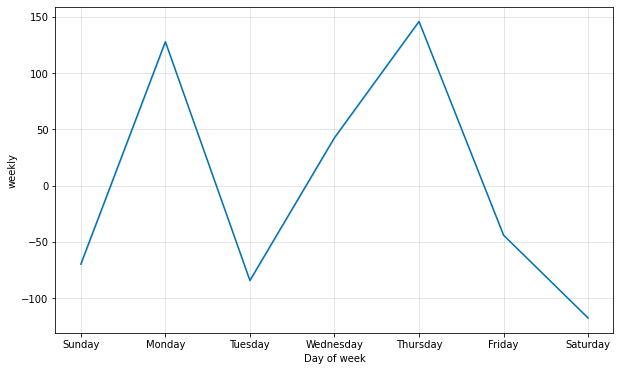

In [ ]:
# visualize each components (trends, monthly)
from fbprophet.plot import plot_weekly
plot_weekly(model2)

In [ ]:
multi_model_2 = df_daily.rename(columns = {'FullDate':'ds','ElecPrice':'y','SysLoad':'add1','GasPrice':'add2'})
multi_model_2.drop('Tmax', axis=1,inplace=True)

In [ ]:
multi_model_2

,index,ds,add1,add2,y
0,0,2010-09-01,41565.38000,88.5600,2751.700
1,1,2010-09-02,38898.99000,88.5600,570.810
2,2,2010-09-03,41665.76000,106.8000,504.975
3,3,2010-09-04,35638.08500,81.3600,502.275
4,4,2010-09-05,35611.41000,106.8000,500.555
...,...,...,...,...,...
3829,3829,2021-02-24,-1525.49745,134.4000,634.770
3830,3830,2021-02-25,4539.07855,130.5048,577.515
3831,3831,2021-02-26,9517.02430,130.1808,1445.495
3832,3832,2021-02-27,4932.88015,130.0800,488.980


In [ ]:
# assign train and test data
train3 = multi_model_2[:2757]
test3 = multi_model_2[2757:]
print('train shape', train3.shape)
print('test shape', test3.shape)

train shape (2757, 5)
test shape (1077, 5)


In [ ]:
#creat multivariate model
model3 = Prophet()
model3.add_regressor('add1')
model3.add_regressor('add2')
# model2.add_regressor('add3')

In [ ]:
model3.fit(train3)
 
forecast3 = model3.predict(test3)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
def mape_3(test3,forecast3):
  mape3 = np.mean(np.abs(np.array(test3['y']) - np.array(forecast3.yhat))/ np.array(test3['y'])) *100
  # rmse2 = np.sqrt(mean_squared_error(np.array(test2['y']),np.array(forecast2['yhat'])))
  return f'mape value is: {round(mape3,2)}'

In [ ]:
mape_3(test3,forecast3)

'mape value is: -64.23'